# Predicting Apartment Prices in Barcelona 2023

Submission for Computational Machine Learning Project 1 - Predicting Apartment Prices in Barcelona

Team: Les Corts

Team members: Vanessa Kromm, Oliver Gatland, Angelo Di Gianvito, Hangze Wu

Notebook layout:

1. Exploratory Data Analysis
2. Data Cleaning and Imputing
3. Cross validation and prediction
4. Annex - Methods that didn't improve the score


## Libraries and data import

### Library import

In [274]:
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Lasso, Ridge
import warnings
warnings.filterwarnings("ignore")

### Data import

In [275]:
# Setting data paths
train_data_path = "./data/train.csv"
test_data_path = "./data/test.csv"

# Reading CSV files
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# Creating column to differentiate df_test and df_train
df_train['train_dummy'] = 1
df_test['train_dummy'] = 0

# Merging dataframes
df = pd.concat([df_train, df_test], axis=0).sort_values("id").reset_index()

## Exploratory Data Analysis

### Initial exploration

In [276]:
# Display the dataframe
display(df)

,index,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price,train_dummy
0,597,1,3.0,3.0,126.0,east,2009.0,6º - 4a,True,True,Sant Martí,9.0,True,True,NaN,NaN,0
1,6521,2,4.0,3.0,154.0,NaN,2008.0,2º - 2a,True,True,Horta,0.0,True,True,NaN,1348.0,1
2,3404,3,1.0,3.0,140.0,NaN,2000.0,4º - 4a,False,True,Sants,6.0,NaN,False,NaN,1285.0,1
3,481,4,3.0,2.0,50.0,south,1984.0,1º - 2a,False,False,Sant Andreu,0.0,False,False,NaN,NaN,0
4,7628,5,3.0,3.0,106.0,south,1959.0,4º - 2a,True,True,Gràcia,1.0,True,True,NaN,1156.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3983,9996,4.0,3.0,51.0,west,1972.0,4º - 4a,False,False,Nou Barris,3.0,False,True,2.0,875.0,1
9996,1028,9997,3.0,3.0,134.0,NaN,1994.0,5º - 2a,False,False,Ciutat Vella,0.0,True,False,3.0,1108.0,1
9997,6572,9998,2.0,1.0,83.0,south,1950.0,9º - 4a,False,False,Les Cors,0.0,True,True,NaN,1083.0,1
9998,1767,9999,2.0,2.0,76.0,west,1998.0,1º - 2a,False,False,Nou Barris,4.0,True,True,3.0,NaN,0


In [277]:
# Data Exploration

# Dataframe shape and variable types
shape = df.shape
print(f"The Dataframe has a shape of {shape[0]} rows and {shape[1]} columns.")
var_types=df.dtypes
print(f"\nThe variable types of the Dataframe are the following:")
display(var_types)

# Descriptive stats
print(f"\nThe descriptives of the Dataframe are the following:")
describe_df = df.describe()
display(describe_df)

The Dataframe has a shape of 10000 rows and 17 columns.

The variable types of the Dataframe are the following:


index                 int64
id                    int64
num_rooms           float64
num_baths           float64
square_meters       float64
orientation          object
year_built          float64
door                 object
is_furnished         object
has_pool             object
neighborhood         object
num_crimes          float64
has_ac               object
accepts_pets         object
num_supermarkets    float64
price               float64
train_dummy           int64
dtype: object


The descriptives of the Dataframe are the following:


,index,id,num_rooms,num_baths,square_meters,year_built,num_crimes,num_supermarkets,price,train_dummy
count,10000.000000,10000.00000,9809.000000,9800.000000,9802.000000,9800.000000,9800.000000,1785.000000,8000.000000,10000.00000
mean,3399.500000,5000.50000,3.175553,1.992449,108.104673,1985.358163,2.776122,1.984314,1099.616250,0.80000
std,2402.896303,2886.89568,7.067345,0.815294,38.442532,20.613132,3.436340,0.804124,271.686617,0.40002
min,0.000000,1.00000,1.000000,1.000000,-100.000000,1950.000000,0.000000,1.000000,195.000000,0.00000
25%,1249.750000,2500.75000,1.000000,1.000000,78.000000,1968.000000,0.000000,1.000000,905.750000,1.00000
50%,2999.500000,5000.50000,3.000000,2.000000,109.000000,1985.000000,1.000000,2.000000,1104.000000,1.00000
75%,5499.250000,7500.25000,4.000000,3.000000,139.750000,2003.000000,6.000000,3.000000,1295.000000,1.00000
max,7999.000000,10000.00000,99.000000,3.000000,170.000000,2021.000000,10.000000,3.000000,2095.000000,1.00000


### Investigating missing values


Missing values per column:

index                  0
id                     0
num_rooms            191
num_baths            200
square_meters        198
orientation         2864
year_built           200
door                 200
is_furnished         200
has_pool             200
neighborhood         200
num_crimes           200
has_ac               200
accepts_pets         200
num_supermarkets    8215
price               2000
train_dummy            0
dtype: int64


Text(0.5, 1.0, 'Missing Data')

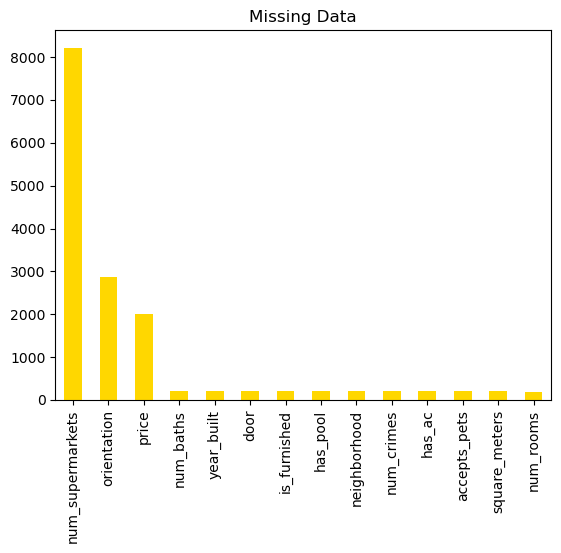

In [278]:
print("Missing values per column:\n")
print(df.isna().sum())
missing = df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing.plot.bar(color='gold')
plt.title('Missing Data')

### Extracting Floor Variable

In [279]:
# Creating numerical floor variable
df['floor'] = df['door'].str.extract(r'(\d+)º').astype(float)
# Dropping door and door_num columns (justification: door number unlikely to be a good predictor for house prices)
df.drop('door', axis=1, inplace=True)

### Distribution of the target variable

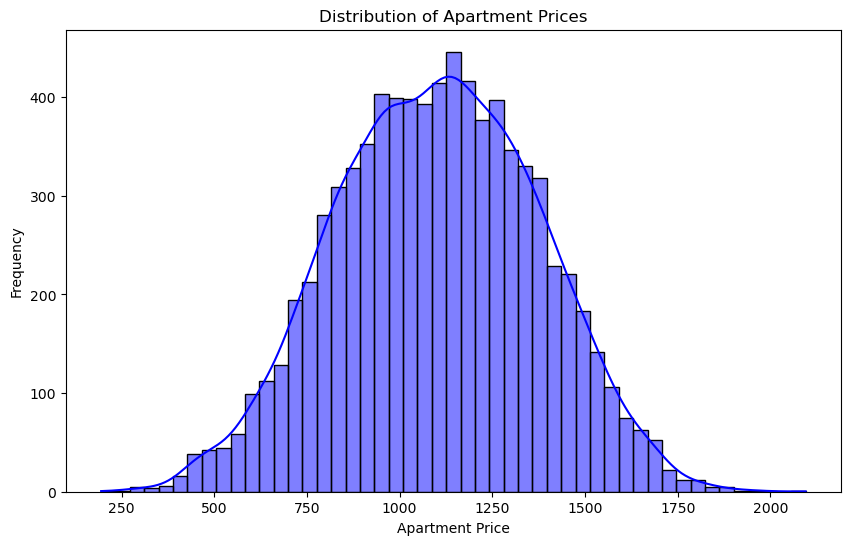

In [280]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, color='blue')
plt.title('Distribution of Apartment Prices')
plt.xlabel('Apartment Price')
plt.ylabel('Frequency')
plt.show()

The histogram shows that prices in the sample are normally distributed and range betweeen about 200 and 2000 dollars.

### Distributions of the numerical variables

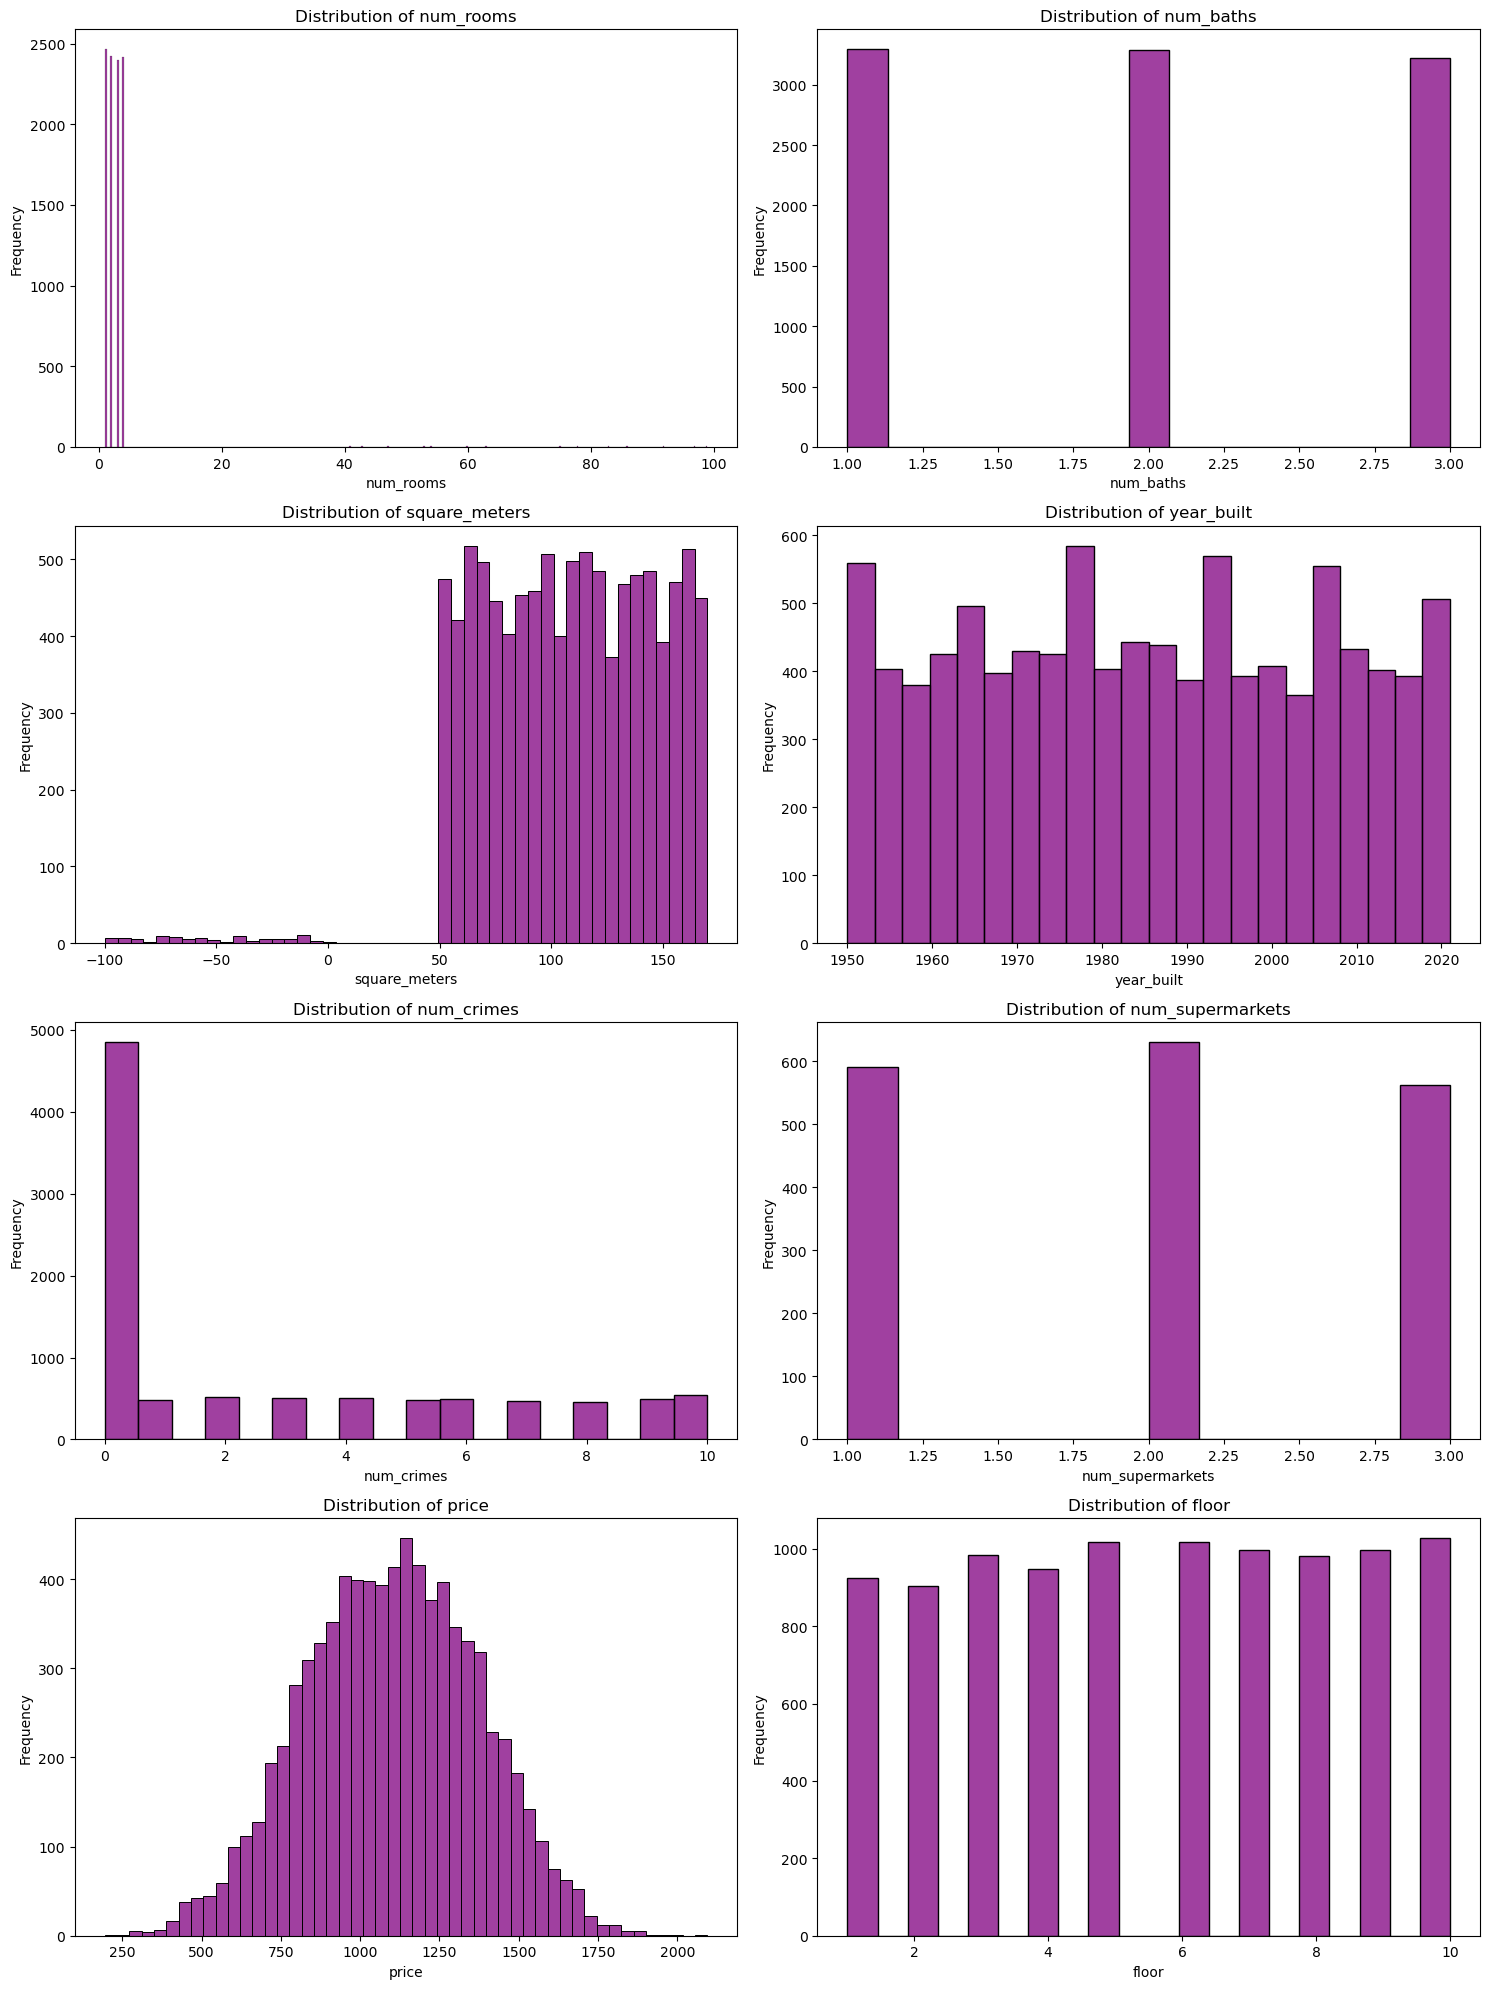

In [281]:
# List of variables to plot
variables = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes', 'num_supermarkets', 'price', 'floor']

# Setting up the subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Creating histograms for each variable
for ax, var in zip(axes.flatten(), variables):
    sns.histplot(df[var], kde=False, ax=ax, color="purple", edgecolor='black')
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

# Adjusting the layout
plt.tight_layout()
plt.show()

### Correlation of the variables with price

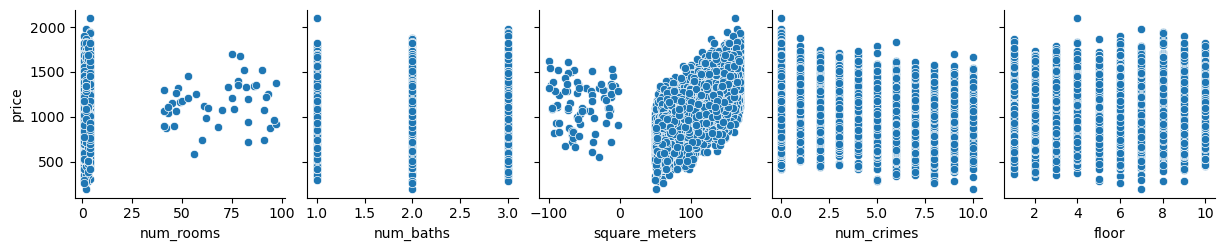

In [282]:
sns.pairplot(df, y_vars=['price'], x_vars=['num_rooms', 'num_baths', 'square_meters', 'num_crimes', 'floor'], kind='scatter', palette='RdYlBu')
plt.show()

#### The most highly correlated feature turns out to be the square meters

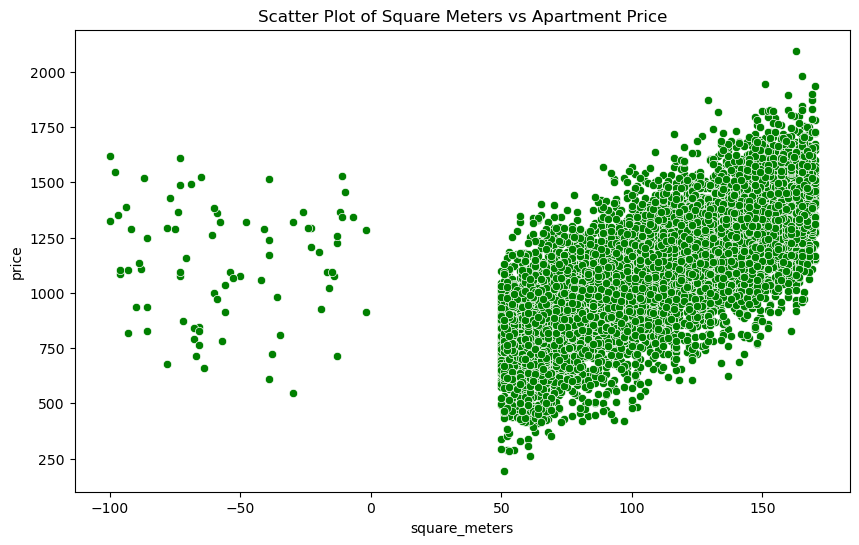

In [283]:
# Scatter plots for important features
plt.figure(figsize=(10, 6))
sns.scatterplot(x='square_meters', y='price', data=df, color='green')
plt.title('Scatter Plot of Square Meters vs Apartment Price')
plt.show()

Variables with missing values will be imputed later. Main variable of concern is num_supermarkets as it has more than 80% of values missing -> If EDA reveals no sensible way to impute we will remove before modelling.

#### Checking binary variables just contain True and False

In [284]:
print(df['is_furnished'].value_counts())
print(df['has_pool'].value_counts())
print(df['has_ac'].value_counts())
print(df['accepts_pets'].value_counts())

is_furnished
False    5046
True     4754
Name: count, dtype: int64
has_pool
False    4906
True     4894
Name: count, dtype: int64
has_ac
True     4940
False    4860
Name: count, dtype: int64
accepts_pets
True     4975
False    4825
Name: count, dtype: int64


### Outliers 

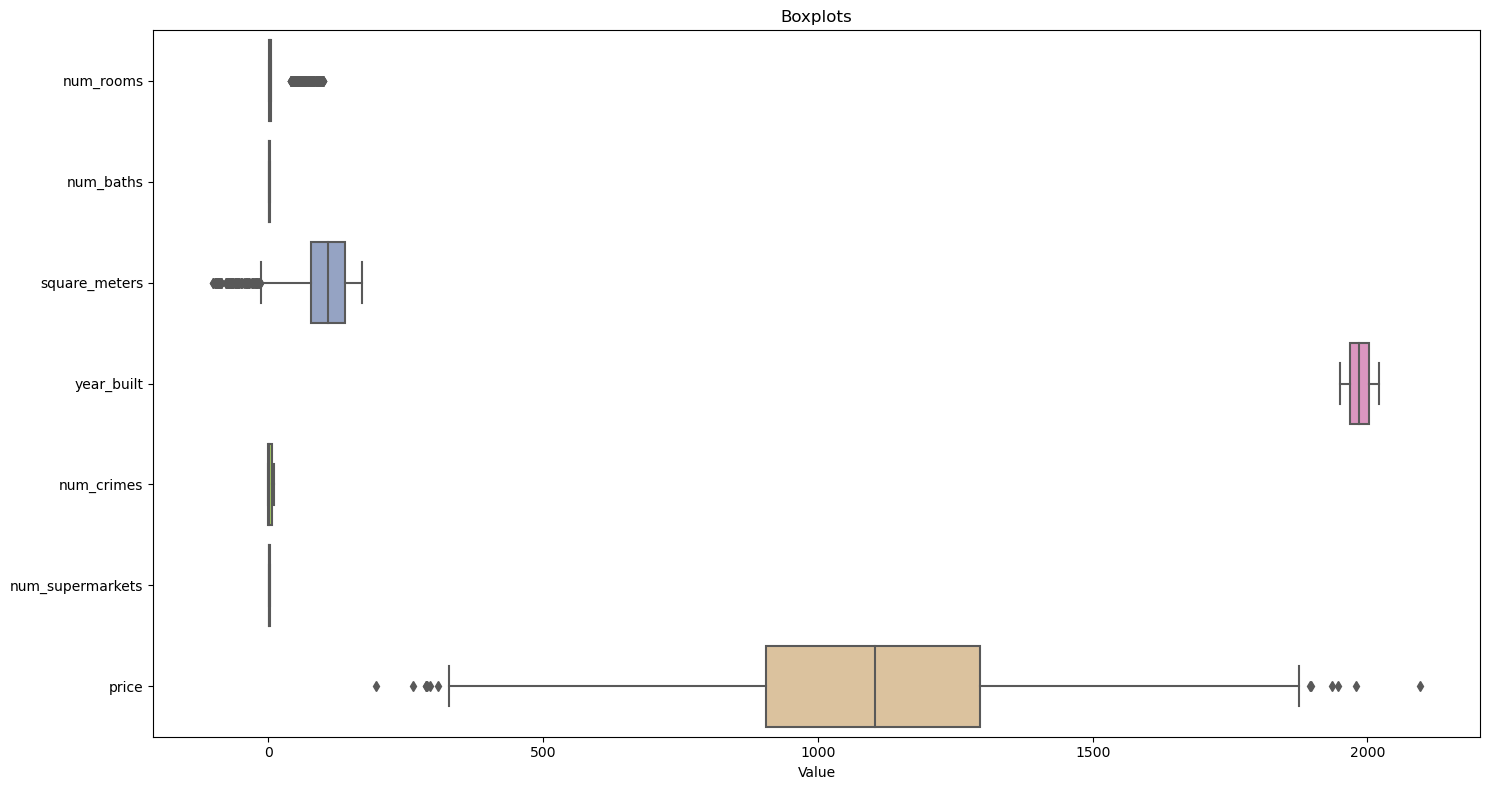

In [285]:
# Look at outlier distribution for non-binary variables
plt.figure(figsize=(15, 8))

sns.boxplot(data=df[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes', 'num_supermarkets', 'price',]], orient="h", palette="Set2")
plt.title("Boxplots")
plt.xlabel("Value")

plt.tight_layout()

# Show the plot
plt.show()

The above plot is hard to interpret due to the different scales across variables. Below investigate each variable more precisely. Note that we will not be dealing with the outliers in price, as this is our target variable so we do not want to alter it.

In [286]:
columns = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes']
data = df.copy()
for col in columns:
    data[col] = data[col].fillna(df[col].mean())
    # Calculate quartiles 25% and 75%
    q25, q75 = np.quantile(data[col], 0.25), np.quantile(data[col], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    # Calculate the number of records below and above lower and above bound value respectively
    outliers = [x for x in data[col] if (x >= upper) | (x <= lower)]
    print(f'The outliers for {col} are {len(outliers)}.')

The outliers for num_rooms are 100.
The outliers for num_baths are 0.
The outliers for square_meters are 93.
The outliers for year_built are 0.
The outliers for num_crimes are 0.


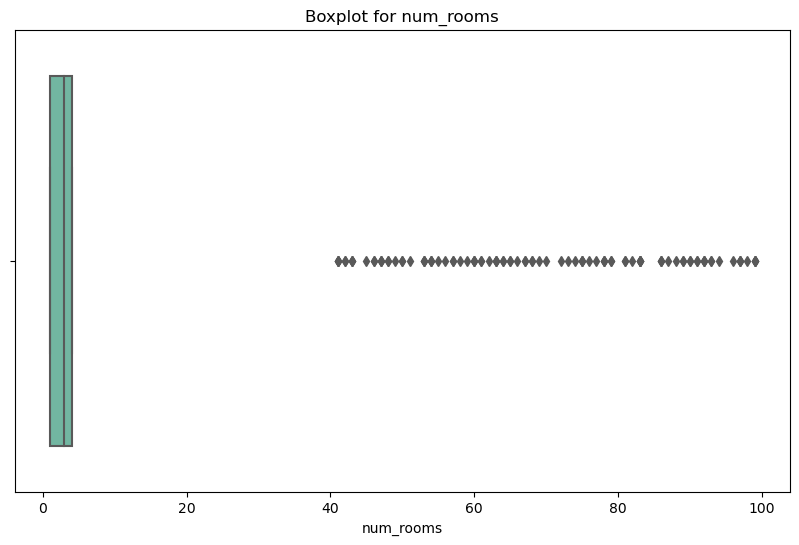

In [287]:
# Focusing on outliers for num_rooms
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['num_rooms'], palette="Set2")
plt.title("Boxplot for num_rooms")
plt.show()

Several outliers in column num_rooms so we investigate this using the standard deviations

In [288]:
threshold=3.0
mean = np.mean(df['num_rooms'])
std = np.std(df['num_rooms'])
cutoff = threshold * std
upper_bound = mean + cutoff
print('The upper bound cut-off is ' + str(round(upper_bound)))

The upper bound cut-off is 24


We will replace all apartments with more than 24 rooms with a NaN, and the missing value will then be imputed.

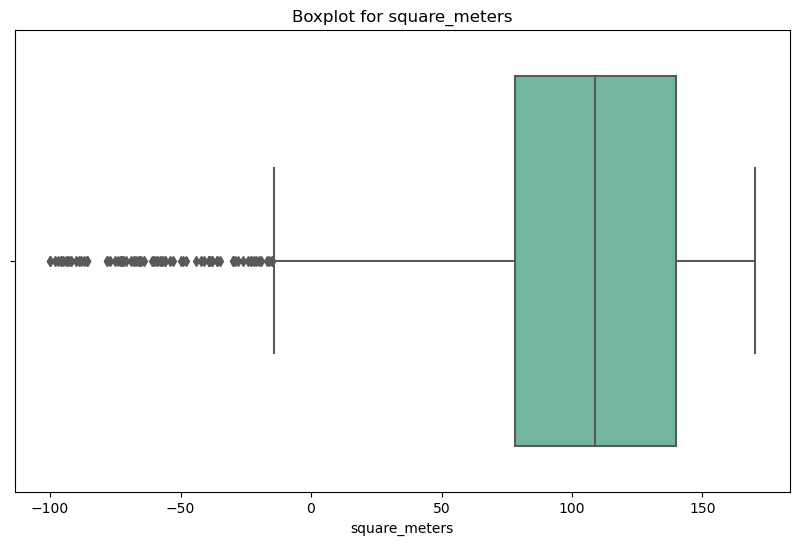

In [289]:
# Focusing on outliers for square_meters
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['square_meters'], palette="Set2")
plt.title("Boxplot for square_meters")

# Show the plot
plt.show()

Outliers in column square_meters: values < 0. Generally negative values for square meters make no sense, so these will be removed.

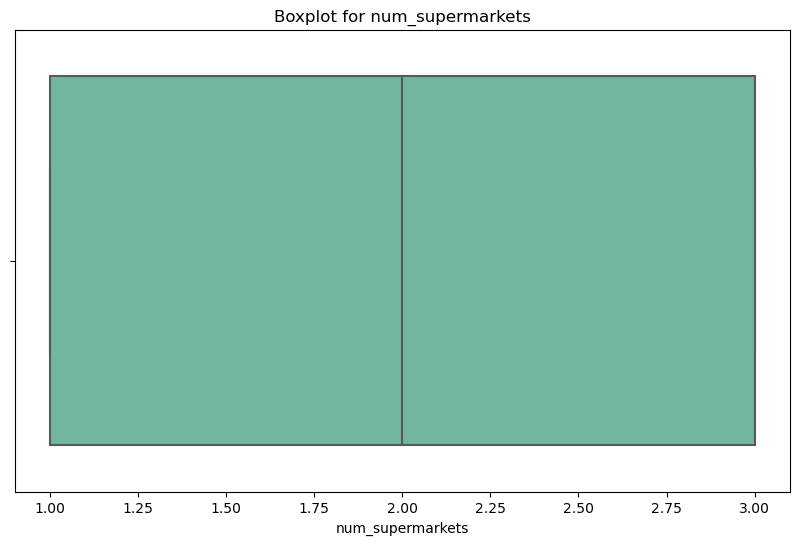

In [290]:
# Focusing on the number of supermarkets

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['num_supermarkets'], palette="Set2")
plt.title("Boxplot for num_supermarkets")

# Show the plot
plt.show()

No outliers presence even in num_supermarkets.

### Correlations

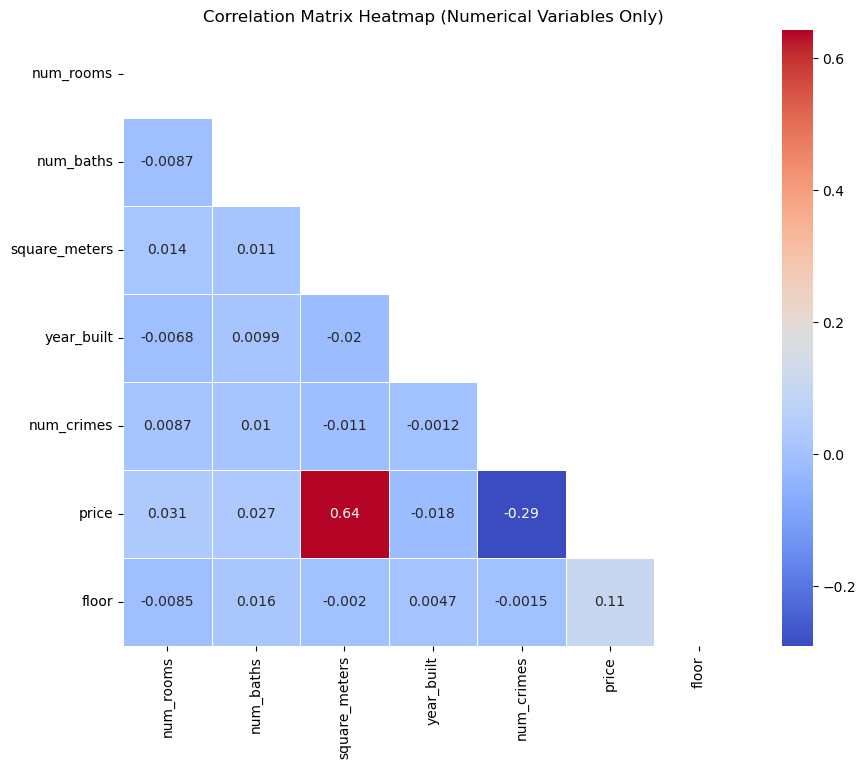

In [291]:
# List of numerical columns to exclude from the correlation matrix
exclude_columns = ['id', 'train_dummy', 'num_supermarkets', 'index']

# Selecting numerical columns except those to be excluded
numerical_columns = [col for col in df.select_dtypes(include='number').columns if col not in exclude_columns]

# Creating a new dataframe with only the selected numerical columns
selected_df = df[numerical_columns]

# Correlation matrix for selected numerical columns
correlation_matrix = selected_df.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correlation_matrix)
# Create a heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=matrix)
plt.title("Correlation Matrix Heatmap (Numerical Variables Only)")
plt.show()

Looking at the above matrix, we can see that square_meters appears to be the most correlated varibale with price, followed by num_crimes. The other variables do not have a strong correlation with price (although this does not mean they will not be useful for prediction), and there doesn't appear to be much collinearity between the variables we will be using for prediction.

## Data cleaning


#### Encoding orientation

In [292]:
print(df['orientation'].value_counts())
# change orientation 'soxth' to 'south'
df['orientation'].replace('soxth', 'south')

print(df['orientation'].isna().sum())
# Missing values need to be filled, KNN only works with numerical values -> map orientations to numbers for KNN

def convert_orientation(orientation):
    mapping = {"north": 1, "east": 2, "south": 3, "west": 4}
    
    if pd.notna(orientation):
        return mapping.get(orientation) 
    else:
        return np.nan


# Map the function to the 'Direction' column to create a new column with numerical values
df['orientation'] = df['orientation'].map(convert_orientation)


orientation
west     1831
north    1787
south    1768
east     1749
soxth       1
Name: count, dtype: int64
2864


#### Removing outliers from the num_rooms and square_meters

In [293]:
# Replacing the outliers with NaN in the number of rooms (justify cutoff value: anything more than 3 std away from the mean, see graph above)
df['num_rooms'] = df['num_rooms'].apply(lambda x: x if x<24 else np.nan)

# Replacing the values of square metres < 0 with NaN (justify cutoff value: outliers for values below 0, see graph above)
df.loc[df['square_meters'] < 0, 'square_meters'] = np.nan

As preannounced the outliers in the square_meters and num_rooms columns have been removed and set to null values.

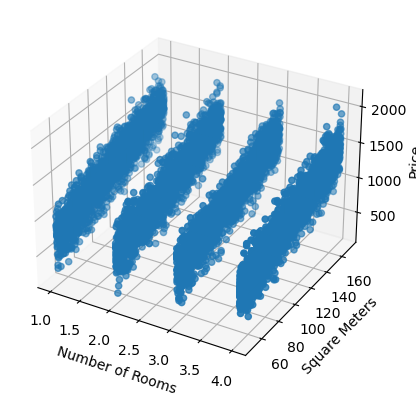

In [294]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['num_rooms'], df['square_meters'], df['price'])
ax.set_xlabel('Number of Rooms')
ax.set_ylabel('Square Meters')
ax.set_zlabel('Price')
plt.show()

The plot shows that there is a similar relationship between square meters and price at different numbers of rooms.

#### Missing values

In [295]:
print("Missing values per column:\n")
print(df.isna().sum())

Missing values per column:

index                  0
id                     0
num_rooms            291
num_baths            200
square_meters        298
orientation         2865
year_built           200
is_furnished         200
has_pool             200
neighborhood         200
num_crimes           200
has_ac               200
accepts_pets         200
num_supermarkets    8215
price               2000
train_dummy            0
floor                200
dtype: int64


### KNN imputing missing values

In [296]:
# Standardization and KNN imputing
def imputing_missing(impute_df, vars_to_impute):
    standardizer = StandardScaler()
    impute_df[vars_to_impute] = standardizer.fit_transform(df[vars_to_impute])
    imputer = KNNImputer(n_neighbors=7)
    impute_df[vars_to_impute] = imputer.fit_transform(df[vars_to_impute])
    impute_df[vars_to_impute] = standardizer.inverse_transform(df[vars_to_impute])
    return impute_df

vars_to_impute = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes', 'floor', 'has_ac', 'accepts_pets', 'is_furnished', 'has_pool', 'orientation']
df = imputing_missing(df, vars_to_impute)

In [297]:
df.head()

,index,id,num_rooms,num_baths,square_meters,orientation,year_built,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price,train_dummy,floor
0,597,1,3.0,3.0,126.0,2.000000,2009.0,1.0,1.0,Sant Martí,9.0,1.000000,1.0,NaN,NaN,0,6.0
1,6521,2,4.0,3.0,154.0,2.714286,2008.0,1.0,1.0,Horta,0.0,1.000000,1.0,NaN,1348.0,1,2.0
2,3404,3,1.0,3.0,140.0,2.571429,2000.0,0.0,1.0,Sants,6.0,0.857143,0.0,NaN,1285.0,1,4.0
3,481,4,3.0,2.0,50.0,3.000000,1984.0,0.0,0.0,Sant Andreu,0.0,0.000000,0.0,NaN,NaN,0,1.0
4,7628,5,3.0,3.0,106.0,3.000000,1959.0,1.0,1.0,Gràcia,1.0,1.000000,1.0,NaN,1156.0,1,4.0


### Standardizing

In [298]:
# Re-standardising variables we want standardised for the modelling
to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes']
standardizer = StandardScaler()
standardize_df = pd.DataFrame() 
standardize_df[to_standardize] = standardizer.fit_transform(df[to_standardize])

for col in to_standardize:
    df[col] = standardize_df[col]

The variables were standardized to improve the performance of the KNN, then the missing values in the sample were imputed using the nearest neighbors method and before the variables were standardized again.

### Label encoding orientation

In [299]:
# Transforming column orientation by one_hot_encoding to get rid of current ordinality for price prediction
print(df['orientation'].value_counts())

# Round values to get "categories" back (KNN process has imputed non-whole numbers)
df['orientation'] = round(df['orientation'],0)

# Remapping for easier One-hot-encoding
mapping = {1: "north", 2: "east", 3: "south", 4:"west"}

df['orientation'] = [mapping[value] for value in df['orientation']]

df = pd.get_dummies(df, columns=['orientation'], prefix=['orient']).reset_index(drop=True)

orientation
3.000000    1992
2.000000    1946
4.000000    1831
1.000000    1787
2.571429     336
2.285714     334
2.714286     311
2.142857     291
2.857143     254
2.428571     243
1.857143     134
3.142857     125
2.428571     109
3.285714      85
1.714286      71
3.571429      21
1.571429      19
3.428571      18
3.428571      14
2.571429      12
1.571429      11
2.857143      11
1.428571       9
3.142857       9
1.857143       7
2.714286       5
3.714286       5
2.142857       3
1.714286       2
1.285714       2
1.000000       1
1.285714       1
1.142857       1
Name: count, dtype: int64


Orientation was label encoded to allow the imputing of missing values

### Imputing neighborhood based on the number of crimes

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Sant Martí'),
  Text(1, 0, 'Horta'),
  Text(2, 0, 'Sants'),
  Text(3, 0, 'Sant Andreu'),
  Text(4, 0, 'Gràcia'),
  Text(5, 0, 'Eixample'),
  Text(6, 0, 'Ciutat Vella'),
  Text(7, 0, 'Sarrià-Sant Gervasi'),
  Text(8, 0, 'Les Cors'),
  Text(9, 0, 'Nou Barris')])

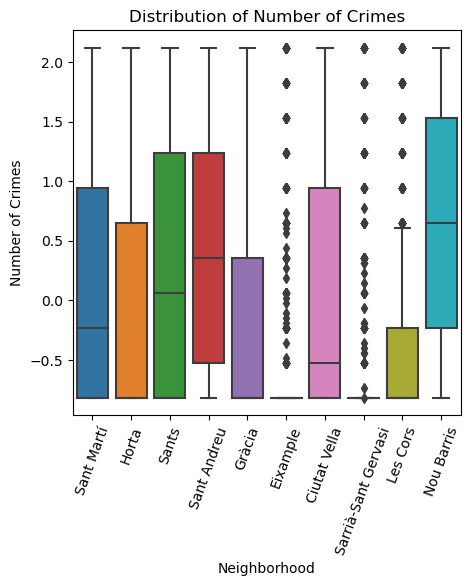

In [300]:
# 200 missing values in neighborhood need to be filled. Investigate if neighborhoods differ by num_crimes
plt.figure(figsize=(5, 5))
sns.boxplot(data = df, x ='neighborhood', y = 'num_crimes')
plt.title('Distribution of Number of Crimes')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=70)

In [301]:
# There are large differences in the mean number of crimes per neighborhood, so we fill the NaN values with the mean for the neighborhood.
crimes_by_neighborhood = df.groupby('neighborhood')['num_crimes'].mean().to_dict()

# Function to be used in the imputation process
def find_closest_key(target, dictionary):
    closest_key = None
    closest_difference = float('inf')

    for key, value in dictionary.items():
        difference = abs(target - value)
        if difference < closest_difference:
            closest_key = key
            closest_difference = difference

    return closest_key

# Imputing neighborhood based on number of crimes
def impute_neighborhood(row):
    crimes = row['num_crimes']
    neighborhood = row['neighborhood']
    if pd.isnull(neighborhood):
        return find_closest_key(crimes, crimes_by_neighborhood)
    else:
        return neighborhood
    
df['neighborhood'] = df.apply(impute_neighborhood, axis=1)

Neighborhood was imputed using the closest mean number of crimes to the value for that particular observation.

### Handling the num_supermarkets column

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Sant Martí'),
  Text(1, 0, 'Horta'),
  Text(2, 0, 'Sants'),
  Text(3, 0, 'Sant Andreu'),
  Text(4, 0, 'Gràcia'),
  Text(5, 0, 'Eixample'),
  Text(6, 0, 'Ciutat Vella'),
  Text(7, 0, 'Sarrià-Sant Gervasi'),
  Text(8, 0, 'Les Cors'),
  Text(9, 0, 'Nou Barris')])

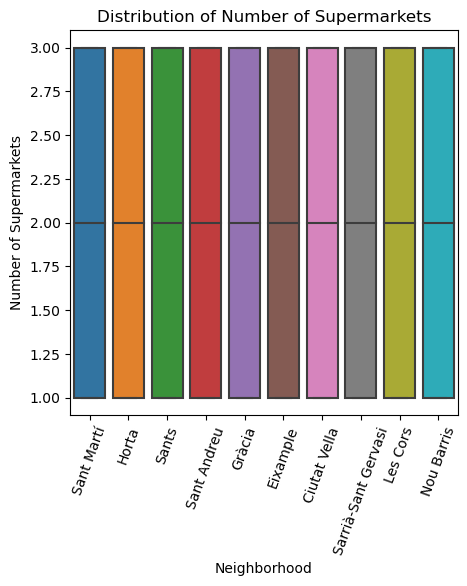

In [302]:
# We first wanted to check if the average number of supermarkets changes by neighborhood, as this could be used to impute.

plt.figure(figsize=(5, 5))
sns.boxplot(data = df, x ='neighborhood', y = 'num_supermarkets')
plt.title('Distribution of Number of Supermarkets')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Supermarkets')
plt.xticks(rotation=70)

Based on the data we have, the mean is very similar for all neighborhoods. Since there is no sensible way to impute and more than 80% of the values are missing, we drop the num_supermarkets column.

In [303]:
# Drop column num_supermarkets
df.drop(['num_supermarkets'], axis=1, inplace=True)

### Closer look at the floor variable

We wanted to investigate if the average price of certain floors are higher than others. This may allow us to create a dummy variable if a particular floor tends to point to a higher price for the apartment.

In [304]:
# After KNN there are also floats for 'floor' so we convert these to integers
df['floor'] = round(df['floor'],0)

floor
1.0     1056.926531
2.0     1051.942172
3.0     1065.078283
4.0     1091.747170
5.0     1089.327626
6.0     1113.609840
7.0     1128.796818
8.0     1122.762452
9.0     1132.267399
10.0    1133.197500
Name: price, dtype: float64


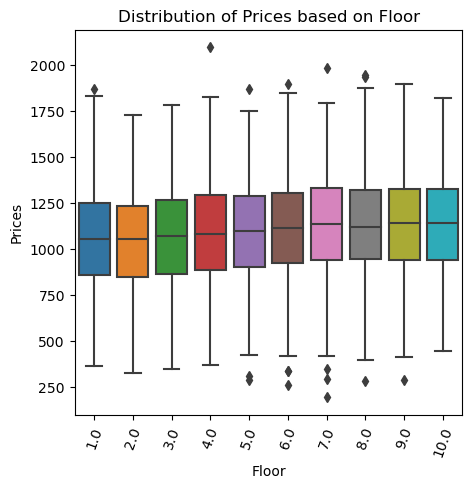

In [305]:
# Looking at prices based on the floor
plt.figure(figsize=(5, 5))
sns.boxplot(data = df, x ='floor', y = 'price')
plt.title('Distribution of Prices based on Floor')
plt.xlabel('Floor')
plt.ylabel('Prices')
plt.xticks(rotation=70)

price_floor = df.groupby('floor')['price'].mean()
print(price_floor)

There is no floor that has a significantly higher price than the others, so we leave the floor variable as it is.

### One hot encoding neighborhood

In [306]:
df = pd.get_dummies(df, columns=['neighborhood'], prefix=['neigh']).reset_index(drop=True)

In [307]:
# Check that all missing values are handeled before modelling
df.isna().sum()

index                           0
id                              0
num_rooms                       0
num_baths                       0
square_meters                   0
year_built                      0
is_furnished                    0
has_pool                        0
num_crimes                      0
has_ac                          0
accepts_pets                    0
price                        2000
train_dummy                     0
floor                           0
orient_east                     0
orient_north                    0
orient_south                    0
orient_west                     0
neigh_Ciutat Vella              0
neigh_Eixample                  0
neigh_Gràcia                    0
neigh_Horta                     0
neigh_Les Cors                  0
neigh_Nou Barris                0
neigh_Sant Andreu               0
neigh_Sant Martí                0
neigh_Sants                     0
neigh_Sarrià-Sant Gervasi       0
dtype: int64

### Seperating the dfs for training and testing

In [308]:
# Seperating test and train
X_train = df[df['train_dummy'] == 1][['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'is_furnished', 'has_pool', 'has_ac', 'accepts_pets', 'orient_north' , 'orient_east', 'orient_south', 'orient_west']]
y_train = df[df['train_dummy'] == 1][['price']]

X_test = df[df['train_dummy'] == 0][['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'is_furnished', 'has_pool', 'has_ac', 'accepts_pets', 'orient_north' , 'orient_east', 'orient_south', 'orient_west']]

## Model Training and Cross Validation

Different models will be trained using the avialble and retrieved data.

In [343]:
# Performing 5-fold cross-validation
def prediction_accuracy(X, y, model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

    # Printing the cross-validation results
    print("Cross-validation results:")
    print(cv_results*(-1))
    print(f"Mean squared error: {(cv_results.mean())*-1:.2f} +/- {cv_results.std():.2f}")

In [344]:
# Test linear regression model
lin_model = LinearRegression()
print(prediction_accuracy(X_train, y_train, lin_model))

Cross-validation results:
[31016.28117188 29255.19726286 29834.18663925 28277.66138605
 28940.08859375]
Mean squared error: 29464.68 +/- 924.35
None


In [345]:
# Predicting prices with linear regression model
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

In [346]:
# Displaying regression coefficients from the linear model
feature_names = X_train.columns
feature_values_lin = lin_model.coef_

linear_coeff = pd.DataFrame(feature_values_lin, columns=feature_names)

# Transpose the DataFrame to have feature names as the index and values as columns
linear_coeff = linear_coeff.transpose()
linear_coeff.columns = ['Value']
linear_coeff['Value'] = linear_coeff['Value'].apply(lambda x: '{:.2f}'.format(x))

# Print the DataFrame
print(linear_coeff)

                                          Value
num_rooms                                 15.91
num_baths                                  8.85
square_meters                            192.72
year_built                                -1.18
floor                                     10.44
num_crimes                               -74.92
neigh_Ciutat Vella           -12753313020113.58
neigh_Eixample               -12753313020111.82
neigh_Gràcia                 -12753313020111.29
neigh_Horta                  -12753313020114.08
neigh_Les Cors               -12753313020110.75
neigh_Nou Barris             -12753313020114.38
neigh_Sant Andreu            -12753313020119.72
neigh_Sant Martí             -12753313020119.04
neigh_Sants                  -12753313020118.68
neigh_Sarrià-Sant Gervasi    -12753313020113.95
is_furnished                               1.61
has_pool                                   7.00
has_ac                                     8.20
accepts_pets                            

In [347]:
# Test linear regression model
lin_model = LinearRegression()
print(prediction_accuracy(X_train, y_train, lin_model))

Cross-validation results:
[31016.28117188 29255.19726286 29834.18663925 28277.66138605
 28940.08859375]
Mean squared error: 29464.68 +/- 924.35
None


In [348]:
df.head()

,index,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,...,neigh_Ciutat Vella,neigh_Eixample,neigh_Gràcia,neigh_Horta,neigh_Les Cors,neigh_Nou Barris,neigh_Sant Andreu,neigh_Sant Martí,neigh_Sants,neigh_Sarrià-Sant Gervasi
0,597,1,0.459369,1.246974,0.469786,1.156493,1.0,1.0,1.826308,1.000000,...,False,False,False,False,False,False,False,True,False,False
1,6521,2,1.362901,1.246974,1.281661,1.107547,1.0,1.0,-0.815241,1.000000,...,False,False,False,True,False,False,False,False,False,False
2,3404,3,-1.347696,1.246974,0.875724,0.715977,0.0,1.0,0.945792,0.857143,...,False,False,False,False,False,False,False,False,True,False
3,481,4,0.459369,0.009756,-1.733872,-0.067163,0.0,0.0,-0.815241,0.000000,...,False,False,False,False,False,False,True,False,False,False
4,7628,5,0.459369,1.246974,-0.110124,-1.290818,1.0,1.0,-0.521735,1.000000,...,False,False,True,False,False,False,False,False,False,False


In [349]:
# Finding optimal alpha values for LASSO and Ridge regressions

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, test_size= 0.2, random_state=42)

# Define a range of alpha values to try
alphas = np.logspace(-10, 0, 50)

# Initialize variables to store the best alpha and minimum MSE
best_alpha_lasso = None
best_alpha_ridge = None
min_mse_lasso = float('inf')
min_mse_ridge = float('inf')

# Loop over the alpha values and fit Lasso and Ridge models
for alpha in alphas:
    # Fit Lasso model
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_temp, y_train_temp)
    y_pred_lasso = lasso.predict(X_test_temp)
    mse_lasso = mean_squared_error(y_test_temp, y_pred_lasso)

    # Update best alpha and minimum MSE for Lasso
    if mse_lasso < min_mse_lasso:
        min_mse_lasso = mse_lasso
        best_alpha_lasso = alpha

    # Fit Ridge model
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X_train_temp, y_train_temp)
    y_pred_ridge = ridge.predict(X_test_temp)
    mse_ridge = mean_squared_error(y_test_temp, y_pred_ridge)

    # Update best alpha and minimum MSE for Ridge
    if mse_ridge < min_mse_ridge:
        min_mse_ridge = mse_ridge
        best_alpha_ridge = alpha

# Print the best alpha and minimum MSE for Lasso and Ridge
print("Best alpha for Lasso:", round(best_alpha_lasso,3))
print()
print("Best alpha for Ridge:", round(best_alpha_ridge,3))



Best alpha for Lasso: 1.0

Best alpha for Ridge: 1.0


In [350]:
# Test LASSO regression model with best alpha
lasso_model = Lasso(alpha=best_alpha_lasso)
print(prediction_accuracy(X_train, y_train, lasso_model))

Cross-validation results:
[30950.93801339 29194.45393162 29714.16870442 28206.09267494
 28794.14241405]
Mean squared error: 29371.96 +/- 931.12
None


In [351]:
# Predicting prices with LASSO regression model
lasso_model.fit(X_train, y_train)
y_pred_LASSO = lasso_model.predict(X_test)

In [352]:
# Displaying regression coefficients for LASSO model
feature_names = X_train.columns
feature_values_lasso = lasso_model.coef_

lasso_coeff = pd.DataFrame({'Feature': feature_names, 'Value': feature_values_lasso})

# Set the feature column as the index
lasso_coeff = lasso_coeff.set_index('Feature')
lasso_coeff['Value'] = lasso_coeff['Value'].apply(lambda x: '{:.2f}'.format(x))

# Print the DataFrame
print(lasso_coeff)

                            Value
Feature                          
num_rooms                   15.00
num_baths                    7.08
square_meters              191.54
year_built                  -0.21
floor                       10.14
num_crimes                 -74.60
neigh_Ciutat Vella           0.00
neigh_Eixample               0.00
neigh_Gràcia                 0.00
neigh_Horta                  0.00
neigh_Les Cors               0.00
neigh_Nou Barris             0.00
neigh_Sant Andreu           -0.00
neigh_Sant Martí            -0.00
neigh_Sants                 -0.00
neigh_Sarrià-Sant Gervasi    0.00
is_furnished                 0.00
has_pool                     2.84
has_ac                       4.16
accepts_pets                -0.00
orient_north                 0.00
orient_east                  0.00
orient_south                -0.00
orient_west                  0.00


In [353]:
# Test Ridge regression model with best alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
print(prediction_accuracy(X_train, y_train, ridge_model))

Cross-validation results:
[31003.61959416 29254.99886134 29834.02776104 28277.65703669
 28927.42203027]
Mean squared error: 29459.55 +/- 921.55
None


In [354]:
# Predicting prices with Ridge regression model
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

In [324]:
# Displaying regression coefficients for Ridge model
feature_names = X_train.columns
feature_values_ridge = ridge_model.coef_

ridge_coeff = pd.DataFrame(feature_values_ridge, columns=feature_names)

# Transpose the DataFrame to have feature names as the index and values as columns
ridge_coeff = ridge_coeff.transpose()
ridge_coeff.columns = ['Value']
ridge_coeff['Value'] = ridge_coeff['Value'].apply(lambda x: '{:.2f}'.format(x))

# Print the DataFrame
print(ridge_coeff)

                            Value
num_rooms                   15.96
num_baths                    8.09
square_meters              192.60
year_built                  -1.17
floor                       10.29
num_crimes                 -74.82
neigh_Ciutat Vella           1.52
neigh_Eixample               3.59
neigh_Gràcia                 3.33
neigh_Horta                  0.87
neigh_Les Cors               3.17
neigh_Nou Barris             0.52
neigh_Sant Andreu           -4.62
neigh_Sant Martí            -4.92
neigh_Sants                 -3.67
neigh_Sarrià-Sant Gervasi    0.21
is_furnished                 1.53
has_pool                     6.91
has_ac                       8.24
accepts_pets                -2.31
orient_north                 0.00
orient_east                  1.23
orient_south                -1.68
orient_west                  0.45


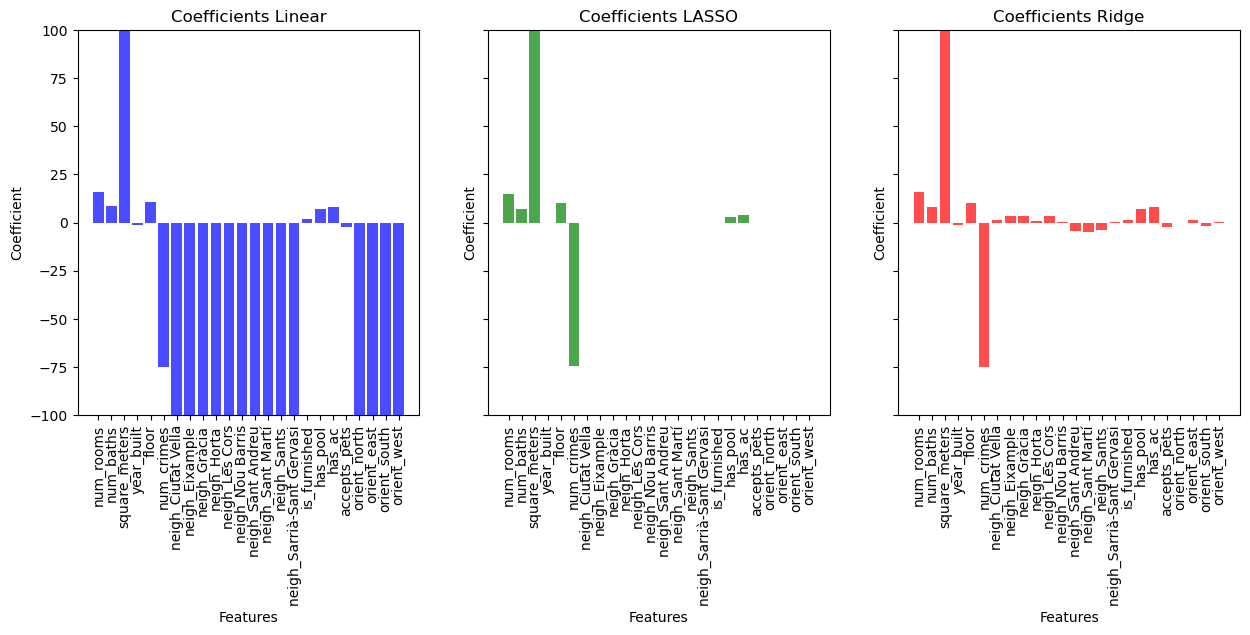

In [355]:
# Displaying regression coefficients for our three models in charts

# Re-shaping the lin and ridge coefficients
feature_values_lin = feature_values_lin.reshape(24)
feature_values_ridge = feature_values_ridge.reshape(24)

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
labels = X_train.columns

# Set common y-axis limits
y_min = -100
y_max = 100


# Linear Regression Coefficients
axes[0].bar(labels, feature_values_lin, color='b', alpha=0.7)
axes[0].set_title('Coefficients Linear')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Coefficient')
axes[0].set_ylim([y_min, y_max])
axes[0].set_xticklabels(labels, rotation=90)

# Lasso Regression Coefficients
axes[1].bar(labels, feature_values_lasso, color='g', alpha=0.7)
axes[1].set_title('Coefficients LASSO')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Coefficient')
axes[1].set_ylim([y_min, y_max])
axes[1].set_xticklabels(labels, rotation=90)

# Ridge Regression Coefficients
axes[2].bar(labels, feature_values_ridge, color='r', alpha=0.7)
axes[2].set_title('Coefficients Ridge')
axes[2].set_xlabel('Features')
axes[2].set_ylabel('Coefficient')
axes[2].set_ylim([y_min, y_max])
axes[2].set_xticklabels(labels, rotation=90)

plt.show()

The coefficients in the Ridge model and very similar to that of the Linear model. This suggests the data does not exhibit high levels of multicollinearity, as this is mainly what the Ridge regression is used to control.

The cross validation shows that the Lasso regression has the lowest MSE score, followed by linear regression and ridge which has the highest MSE.
By looking at the coefficients you can clearly see that Lasso has removed unecessary features by shrinking some coefficents to 0. These include all neighborhood variables. Also all the variables for orientation are set to 0 now, as well as is_furnished.
Based on the coefficients you can say that square_meters has the highest impact on the apartment price, followed by num_crimes which has a negative effect. 

### Exporting best prediction

In [ ]:
pred_df = pd.DataFrame()
pred_df['id'] = df[df['train_dummy'] == 0]['id']
pred_df['pred'] = y_pred_LASSO

# Insert export file path below
export_data_path = 'C:/Users/gatla/OneDrive/BSE/Computational_machine_learning/Project_1/checking_changes.csv'
pred_df.to_csv(export_data_path, index=False)

## Annex - Methods that didn't improve the score

#### using mean of year_built to impute NAs instead of KNN

In [ ]:
# looking at year built
df['year_built'].hist()
plt.show()

# quite equally distributed
# look whether there are differences based on neighborhood
mean_year_per_neigh = df.groupby('neighborhood')['year_built'].mean()
print(mean_year_per_neigh)
# no differences, just impute mean of year built
df['year_built'] = df['year_built'].fillna(df['year_built'].mean())

#### changing the number of rooms for those with outliers in sqm_per_room

In [ ]:
mean_sqm_to_room = df.groupby('num_rooms')['square_meters'].mean()
print(mean_sqm_to_room)

# seems odd that the mean size of the apartments is nearly the same for all num_rooms
# creating a new variable: square meters per room and look at the outliers (only if square_meter is positive, closer look at negative values later)
def calculating_sqm_per_room(row):
    if row['square_meters'] > 0:
        return row['square_meters']/ row['num_rooms']
    else:
        row['sqm_per_room'] = pd.NA    
df['sqm_per_room'] = df.apply(calculating_sqm_per_room, axis=1)
sns.boxplot(data=df['sqm_per_room'], palette="Set2")
plt.show()

# outliers detected from boxplot, take a closer look

upper_bound = 100
print(upper_bound)
df[df['sqm_per_room']>upper_bound]['num_rooms'].value_counts()

# nearly all rows that have an outlier as sqm_per_room have only 1 room. This doesn't make sense. Change this data with mean of sqm_per_room of non outliers

median_sqm_per_room = df[df['sqm_per_room'] < upper_bound]['sqm_per_room'].median()
print(median_sqm_per_room)

def changing_num_rooms_in_outliers(row):
    if row['square_meters'] >0 and pd.notna(row['num_rooms']):
        if row['sqm_per_room'] < upper_bound:
            return row['num_rooms']
        else:
            return round(row['square_meters'] / median_sqm_per_room,0)
    else:
        return row['num_rooms']    
    
df['num_rooms'] = df.apply(changing_num_rooms_in_outliers, axis=1)

#### imputing binary variables with logistic regressions for each column

In [ ]:
# imputing binary variables with logistic regression

correlation_matrix = df.corr(method='pearson')

# Calculate the correlation of all columns with respect to the 'price' column
price_correlation = correlation_matrix['price']

price_correlation = price_correlation.drop('price')
plt.figure(figsize=(12, 8))
sns.heatmap(price_correlation.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.show         

#order do impute (from lowest to highest correlation): has_pool, is_furnished, has_ac, accepts_pets

# imputing has_pool
df['has_pool'] = df['has_pool'].map({True: 1, False: 0})
df_train = df[df['has_pool'].notna()]
df_test = df[df['has_pool'].isna()]
X_train = df_train[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi']]
y_train = df_train['has_pool']
X_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi']]

# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the data
logreg.fit(X_train, y_train)

# Predict the class labels
predicted_labels = logreg.predict(X_test)
df.loc[df['has_pool'].isna(), 'has_pool'] = predicted_labels


# imputing is_furnished
df['is_furnished'] = df['is_furnished'].map({True: 1, False: 0})
df_train = df[df['is_furnished'].notna()]
df_test = df[df['is_furnished'].isna()]
X_train = df_train[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool']]
y_train = df_train['is_furnished']
X_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool']]

# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the data
logreg.fit(X_train, y_train)

# Predict the class labels
predicted_labels = logreg.predict(X_test)
df.loc[df['is_furnished'].isna(), 'is_furnished'] = predicted_labels


# imputing has_ac
df['has_ac'] = df['has_ac'].map({True: 1, False: 0})
df_train = df[df['has_ac'].notna()]
df_test = df[df['has_ac'].isna()]
X_train = df_train[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool', 'is_furnished']]
y_train = df_train['has_ac']
X_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool', 'is_furnished']]

# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the data
logreg.fit(X_train, y_train)

# Predict the class labels
predicted_labels = logreg.predict(X_test)
df.loc[df['has_ac'].isna(), 'has_ac'] = predicted_labels


# imputing has_ac
df['accepts_pets'] = df['accepts_pets'].map({True: 1, False: 0})
df_train = df[df['accepts_pets'].notna()]
df_test = df[df['accepts_pets'].isna()]
X_train = df_train[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool', 'is_furnished', 'has_ac']]
y_train = df_train['accepts_pets']
X_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool', 'is_furnished', 'has_ac']]

# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the data
logreg.fit(X_train, y_train)

# Predict the class labels
predicted_labels = logreg.predict(X_test)
df.loc[df['accepts_pets'].isna(), 'accepts_pets'] = predicted_labels

With imputing binary variables with logistic regression instead of KNN: MSE score increases to 30076.70033997275

-> better to use KNN

#### Winsorizing the outliers in price: only reduced MSE in traindata, MSE in kaggle was increased -> overfitting!

In [ ]:
# Windsorizing price outliers in train data
def winsorize(data, limits=(0.05, 0.05)):
    """
    Winsorize a dataset by replacing extreme values with less extreme values.

    Arguments:
    - data: 1-D array or list, the dataset to be winsorized.
    - limits: Tuple of two floats (lower, upper), representing the fraction of values to be replaced
              on each tail. Default is (0.05, 0.05), which replaces 5% of the values on each tail.

    Returns:
    - winsorized_data: 1-D array, the winsorized dataset.
    """
    # Copy the input data to avoid modifying the original array
    winsorized_data = np.copy(data)


    # Calculating the lower and upper limits for winsorization
    lower_limit = np.percentile(winsorized_data, limits[0] * 100)
    upper_limit = np.percentile(winsorized_data, 100 - limits[1] * 100)

    print('Lower limit:', lower_limit)
    print('Upper limit:', upper_limit)

    # Replacing values below the lower limit with the lower limit
    winsorized_data[winsorized_data < lower_limit] = lower_limit

    # Replacing values above the upper limit with the upper limit
    winsorized_data[winsorized_data > upper_limit] = upper_limit

    return winsorized_data

# Windsorizing the price variable
df_train['price'] = winsorize(df_train['price'].dropna(), limits=(0.05, 0.05))

#### feature engineering: creating the column 'sqm_per_room'

In [ ]:
df['sqm_per_room'] = df['square_meters'] / df['num_rooms']